In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy import stats
from scipy.fftpack import fft, ifft
import bisect 
from scipy import signal
import pandas as pd
import seaborn as sns
from cdt.metrics import SHD
from cdt.metrics import precision_recall
import time
import random
import heapq
import lingam
import warnings

from spikegraph import *
from helpers import *

warnings.filterwarnings("ignore")

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


In [2]:
graphtype = 'outwfork' # options: {chain, cycle, inwfork, outwfork}

In [3]:
fn1=f'../data/groundtruth/{graphtype}3node.txt'
gt = getGroundTruth(fn1)

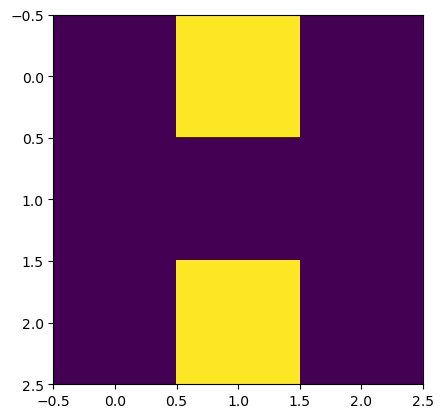

In [4]:
plt.imshow(gt)

K, T: (481, 21)
Unique elements and their counts:
Element: 0, Count: 8829
Element: 6, Count: 74
Element: 5, Count: 167
Element: 4, Count: 392
Element: 2, Count: 156
Element: 1, Count: 378
Element: 7, Count: 84
Element: 3, Count: 21
Counter({0: 8829, 4: 392, 1: 378, 5: 167, 2: 156, 7: 84, 6: 74, 3: 21})
[tab] 0000  tot=2.0761  var=0.0000  nll=2.0760
[tab] 0050  tot=0.4436  var=0.0165  nll=0.4271
[tab] 0100  tot=0.5092  var=0.0061  nll=0.5031
[tab] 0150  tot=0.4885  var=0.0022  nll=0.4862
[tab] 0200  tot=0.3697  var=0.0022  nll=0.3675
[tab] 0250  tot=0.4739  var=0.0207  nll=0.4532
[tab] 0300  tot=0.5093  var=0.0015  nll=0.5078
[tab] 0350  tot=0.4802  var=0.0018  nll=0.4784
[tab] 0400  tot=0.4246  var=0.0024  nll=0.4222
[tab] 0450  tot=0.5322  var=0.0180  nll=0.5143
[tab] 0499  tot=0.4356  var=0.0027  nll=0.4329


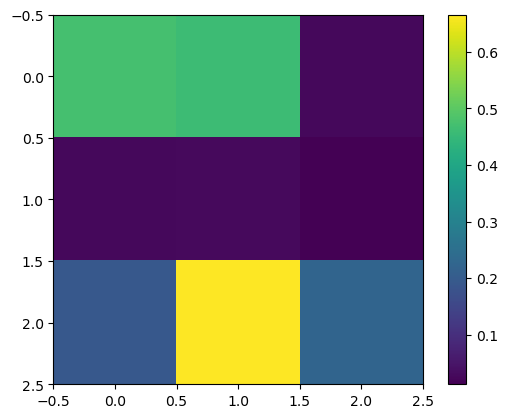

In [5]:
fn2 = f'../data/spikedatafromNEURON/{graphtype}3node/rasterplot-3node_0.txt'

tstop = 3
duration = tstop*1000
N = 3
h = 6
T = 20
states_np, idx = enumerate_states_binary(N)

numSpikes, spikeTimes = getSpikesInfo(fn2)
data = getBinarizedSpikeMatrix(spikeTimes, tstop, N, h)
paths = prepare_paths_from_spikes(data, T)

K, T = np.shape(paths)
print(f"K, T: {K, T}")
print(count_unique_elements(paths))

@dataclass
class CFG:
    N: int = N
    T: int = T
    K: int = K
    seed: int = 123
    lr_tab: float = 1e-1
    iters_tab: int = 500
    lr_nn: float = 3e-4
    iters_nn: int = 1500
    hidden: int = 64
    batch_m: int = 256
    nll_coeff: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

cfg = CFG(N=N, T=T-1, K=K)
device = torch.device(cfg.device)
paths_t = torch.tensor(paths, device=device)

# Train transition matrix
P_tab, loss_tab_tot, loss_tab_var, loss_tab_nll = train_tabular(cfg, states_np, paths_t, device)

Δ_tab = influence(P_tab, states_np); Adj_tab = adjacency(Δ_tab)

plt.imshow(Δ_tab)
plt.colorbar()

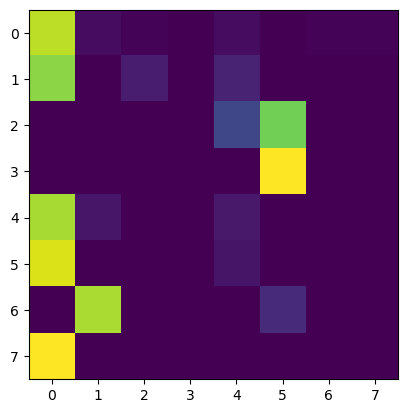

In [6]:
plt.imshow(P_tab)

In [7]:
P_tab @ (states_np==1).astype(float)

array([[0.05564292, 0.03195918, 0.04940001],
       [0.09546916, 0.08160174, 0.0015916 ],
       [0.99811047, 0.00159474, 0.78437893],
       [0.9960053 , 0.00134945, 0.99618651],
       [0.07154351, 0.00211206, 0.06380582],
       [0.05626731, 0.00140756, 0.00153002],
       [0.12592495, 0.00172214, 0.99722549],
       [0.00165186, 0.00170498, 0.00180105]])

In [8]:
states_np

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]], dtype=int8)

In [9]:
idx

{(0, 0, 0): 0,
 (0, 0, 1): 1,
 (0, 1, 0): 2,
 (0, 1, 1): 3,
 (1, 0, 0): 4,
 (1, 0, 1): 5,
 (1, 1, 0): 6,
 (1, 1, 1): 7}